# Interactive clustering example

Here we will use the new interactive tool for interactive clustering.

You can integrate this with your workflow to fix clustering issues. To illustrate, I've duplicated the first part of the analysis template here. We then correct a clustering issue with the interactive clustering tool, and pipe the droplets DataFrame back into the rest of the pipeline (not shown here). 

# Inputs

In [20]:
exp_date = '20200323_'
UV_bin = '_UV0'
Notes_path = '../Notes_210.xlsx'
config_file ="../20200323_Kyla_med_config.yml"
newfolder = "../20200323_kyla_med_25k_4r5c_output/"
droplets_csv = exp_date+'droplets_found'+UV_bin+'_corresponding_bkg_sub.csv'

# Imports

In [21]:
# basic imports 
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Append top level directory with kchip package
import sys
sys.path.append('../../../')

# kchip imports
import kchip.io as kchip_io
import kchip.analyze as kchip_analyze

# Other
%matplotlib inline

# Read in config file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)
    
print yaml.dump(config)

barcodes:
  cluster:
    eps: 0.03
    min_samples: 2
    offset:
    - 0
    - 0
    - 0
    points_to_cluster: 2000
  path: ./Notes_210.xlsx
image:
  background_image: image
  base_path: ./med_25k_4r5c
  base_path_bkg: ./med_25k_4r5c_bg
  bugs: 3
  dyes:
  - 1
  - 0
  - 2
  - 4
  names:
    premerge: image
  overlap: 0.075
  pixel_size: 6.5
  rescale:
  - 1.7
  - 1
  - 3.4
  - 1
  - 12.1
  size: 2048
  well_start_image:
  - 1
  - 2
  well_start_xy:
  - 540
  - 140
well_mask:
  filename: kchip/well_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 850
  - 522



/Users/mzhu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


# Plotting parameters

In [4]:
fontsize = 14
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False

plt.rcParams['axes.linewidth']=3
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=2
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['pdf.fonttype'] = 42

# Load in droplets DataFrame

In [22]:
# Read in droplets file
droplets = pd.read_csv(newfolder+droplets_csv,index_col=0)
config['barcodes']['path'] = Notes_path

# Initial Clustering

NameError: name 'newfolder' is not defined

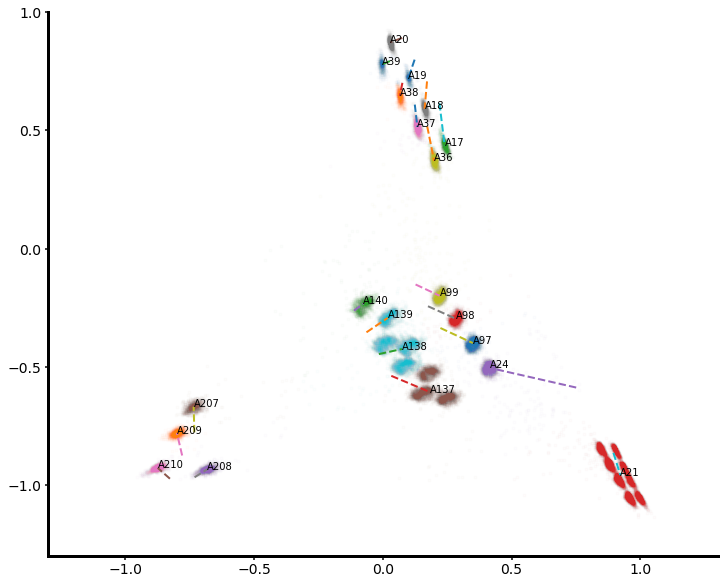

In [24]:
# Mess up clustering parameters to force bad clustering, for illustration
config['barcodes']['cluster']['eps'] = 0.02
config['barcodes']['cluster']['min_samples'] = 4

fig, ax = plt.subplots()

# Identify the clusters (using DBSCAN)
droplets = kchip_analyze.identify_clusters(config,droplets,show=1,ax=ax)[0]

# Map the cluster centroids to labels
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)[0]
plt.gca().set_xlim(-1.3,1.3)
plt.gca().set_ylim(-1.3, 1)
plt.gcf().set_size_inches(12,10)
plt.savefig(newfolder+exp_date+'uncorrected_clusters_'+UV_bin+'.png',dpi=300)

In [30]:
print('Cluster #',droplets.Cluster.unique().shape)

('Cluster #', (20,))


# Correct Clustering

In [31]:
# Import the interactive tools
import kchip.tools.interact as interact

# Create InteractiveCluster object
centroids = droplets.groupby('Cluster')[['PlaneX','PlaneY']].median().values
rc = interact.InteractiveCluster(droplets[['PlaneX','PlaneY']].values[-5000:,:],centroids)

Don't forget to call `interact.bqplt.show()` in order to show the plot. You can now click on points to add a cluster, or click on the cluster centroid to remove the cluster. As you add and remove the points will re-cluster in response. 

In [32]:
# import bqplot as bqplt
# Show the plot
interact.bqplt.show()

# Change the point opacities for better viewing, as desired
rc.sca_points.default_opacities = [0.7]

VkJveChjaGlsZHJlbj0oRmlndXJlKGF4ZXM9W0F4aXMob3JpZW50YXRpb249J3ZlcnRpY2FsJywgc2NhbGU9TGluZWFyU2NhbGUoKSwgc2lkZT11J2xlZnQnKSwgQXhpcyhzY2FsZT1MaW5lYXLigKY=


After we are satisfied, we can then update the droplets DataFrame. 

In [33]:
# Update the droplets dataframe with new cluster assignments
droplets['Cluster']=rc.cluster(droplets[['PlaneX','PlaneY']].values)

Finally, remap the barcodes to the cluster centroids using `map_labels_to_clusters`.

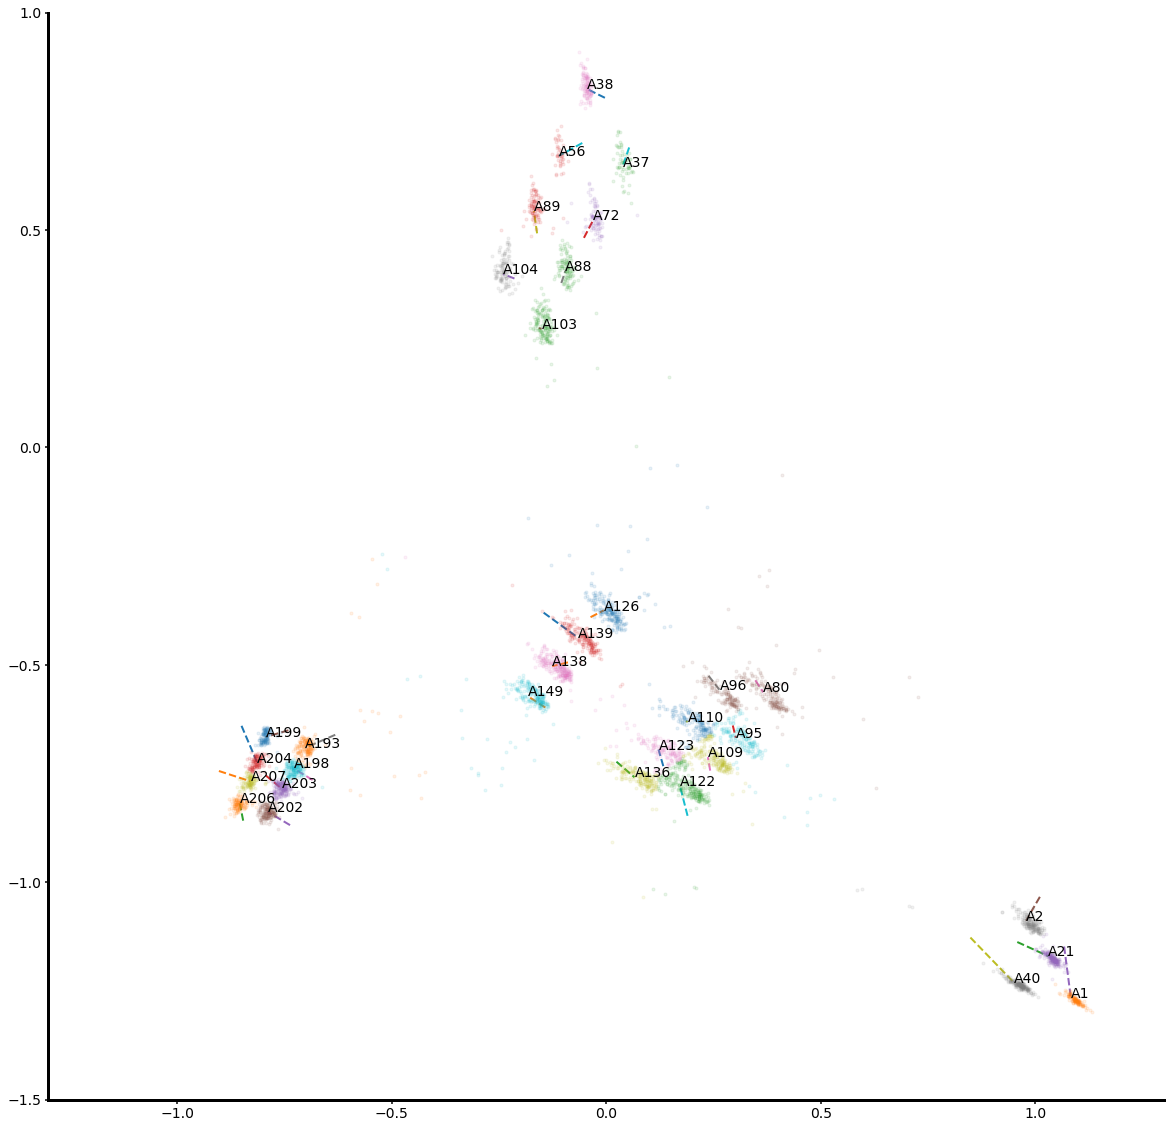

In [35]:
fig, ax = plt.subplots(figsize=(50,50))

# Use the updated cluster centroids from the interactive plot
droplets,_ = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)
# Replot the points to view the clusters
d = droplets.loc[:10e3] # only choose the first 5000 points so we don't overload matplotlib

for item in droplets['Cluster'].unique():
    xy = d.query('Cluster=='+str(item))[['PlaneX','PlaneY']].values
    ax.plot(xy[:,0],xy[:,1],'.',alpha=0.1)
plt.gca().set_xlim(-1.3,1.3)
plt.gca().set_ylim(-1.5, 1)
plt.gcf().set_size_inches(20,20)
plt.savefig(newfolder+exp_date+'clusters_corrected'+UV_bin+'.png',dpi=300)#,bbox_inches='tight')

# Save corrected clusters 

In [36]:
# Save as csv, reload that into analysis notebook!!!
droplets.to_csv(newfolder+exp_date+'droplets_clustered_corrected'+UV_bin+'.csv')